## project_game_app
Проджект-менеджер дал задачу проанализировать данные по исследованию нескольких аспектов мобильного приложения для игр:
 
> ## 1
Retention – один из самых важных показателей в компании. Нужно написать функцию, которая будет считать retention игроков по дням от даты регистрации игрока, она должна работать как на полном датасете, так и на части (сэмпле) данных.
<br>
Данные для анализа:
- problem1-reg_data.csv – данные о времени регистрации
<br>
- problem1-auth_data.csv – данные о времени захода пользователей в игру


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy import stats
from scipy.stats import bootstrap, chi2_contingency
import pingouin as pg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import requests
from urllib.parse import urlencode

In [12]:
# функция выгрузки данных через API
def func_yandex_csv(public_key, sep, encoding):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep, encoding=encoding) 

In [13]:
public_key_reg = 'https://disk.yandex.ru/d/qhURskdnk67lkw'

In [14]:
reg_data = func_yandex_csv(public_key_reg, sep=';', encoding='utf-8')
reg_data['reg_date_time'] = pd.to_datetime(reg_data['reg_ts'], unit='s', origin='unix', errors='coerce')
reg_data.head(3)

,reg_ts,uid,reg_date_time
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27


In [11]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   reg_ts         1000000 non-null  int64         
 1   uid            1000000 non-null  int64         
 2   reg_date_time  1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 22.9 MB


In [4]:
reg_data.shape[0]

1000000

In [5]:
reg_data.nunique()

reg_ts           1000000
uid              1000000
reg_date_time    1000000
dtype: int64

In [6]:
reg_data.reg_date_time.min()

Timestamp('1998-11-18 09:43:43')

In [7]:
reg_data.reg_date_time.max()

Timestamp('2020-09-23 15:17:24')

> в данных о времени регистрации нет пропусков и все значения являются уникальными

In [16]:
public_key_auth = 'https://disk.yandex.ru/d/j3l1F7pS5vfhjA'

In [18]:
# данные о времени захода пользователей в игру
auth_data = func_yandex_csv(public_key_auth, sep=';', encoding='utf-8')
auth_data['auth_date_time'] = pd.to_datetime(auth_data['auth_ts'], unit='s', origin='unix', errors='coerce')
auth_data.head(3)

,auth_ts,uid,auth_date_time
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46


In [9]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   auth_ts         int64         
 1   uid             int64         
 2   auth_date_time  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 219.7 MB


In [10]:
auth_data.shape[0]

9601013

In [11]:
auth_data.nunique()

auth_ts           9180915
uid               1000000
auth_date_time    9180915
dtype: int64

In [12]:
auth_data.duplicated().sum()

0

In [13]:
auth_data.isna().sum()

auth_ts           0
uid               0
auth_date_time    0
dtype: int64

In [14]:
auth_data.auth_date_time.min()

Timestamp('1998-11-18 09:43:43')

In [15]:
auth_data.auth_date_time.max()

Timestamp('2020-09-23 15:17:24')

> в данных по времени пользователей нет дубликатов и пропусков, данные за 22 года

> ### Напишем функцию расчета Retention rate

> = ((количество клиентов на конец периода - количество новых клиентов за период) / количество клиентов в начале периода ) * 100%

In [16]:
def calculate_retention(reg_file_path, auth_file_path, start_date=None, end_date=None, cohort_type='daily'):
    
    reg_data = pd.read_csv(reg_file_path, sep=';', encoding='utf-8')
    reg_data['reg_datetime'] = pd.to_datetime(reg_data['reg_ts'], unit='s', origin='unix', errors='coerce')
    
    
    auth_data = pd.read_csv(auth_file_path, sep=';', encoding='utf-8')
    auth_data['auth_datetime'] = pd.to_datetime(auth_data['auth_ts'], unit='s', origin='unix', errors='coerce')
    
    # Фильтрация по начальной и конечной дате
    if start_date:
        start_date = pd.to_datetime(start_date)
        reg_data = reg_data[reg_data['reg_datetime'] >= start_date]
        auth_data = auth_data[auth_data['auth_datetime'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        reg_data = reg_data[reg_data['reg_datetime'] <= end_date]
        auth_data = auth_data[auth_data['auth_datetime'] <= end_date]
    
    # Основная таблица - таблица с дествиями пользователей. Объединяем датафреймы, используя left join.
    merged_data = auth_data.merge(reg_data, how = 'left', on = 'uid')
    
    
    if cohort_type == 'daily':
        
        # Создадим столбец с днём действия
        merged_data['auth_day'] = merged_data['auth_datetime'].dt.to_period('D')
        # Определение когорт по дням регистрации
        merged_data['cohort_day'] = merged_data['reg_datetime'].dt.to_period('D')
        # Группируем данные по когортам и дням действий пользователей из данных когорт
        cohort_data = merged_data.groupby(['cohort_day', 'auth_day'])\
            .agg({'uid': 'nunique'})\
            .reset_index()\
            .rename(columns={'uid':'nunique_of_uid'})
        # Рассчитываем retention rate
        # Рассчитываем количество периодов (дней) между днями заказа (auth_day) 
        # и днем первой покупки (cohort_day)
        cohort_data['period_number'] = (cohort_data['auth_day'] - cohort_data['cohort_day']).apply(lambda x: x.n)
        # Рассчитываем retention rate для каждого периода (дня) в каждой когорте. 
        # Для этого мы берем количество уникальных пользователей в каждом периоде (nunique_of_uid) 
        # и делим его на максимальное количество уникальных пользователей в когорте 
        # (получается, делим на то количество пользователей, которые совершили первую покупку в день, определяющий данную когорту).
        cohort_data['retention_rate'] = \
            cohort_data['nunique_of_uid'] / cohort_data.groupby('cohort_day')['nunique_of_uid'].transform('max')
        # Создание сводной таблицы для построения тепловой карты
        retention_pivot = cohort_data.pivot(index='cohort_day',
                                            columns='period_number',
                                            values='retention_rate')
        
    elif cohort_type == 'weekly':
        
        # Создадим столбец с неделей действия
        merged_data['auth_week'] = merged_data['auth_datetime'].dt.to_period('W-MON')
        # Определение когорт по неделям регистрации
        merged_data['cohort_week'] = merged_data['reg_datetime'].dt.to_period('W-MON')
        # Группируем данные по когортам и неделям действий пользователей из данных когорт
        cohort_data = merged_data.groupby(['cohort_week', 'auth_week'])\
            .agg({'uid': 'nunique'})\
            .reset_index()\
            .rename(columns={'uid':'nunique_of_uid'})
        # Рассчитываем retention rate
        # Рассчитываем количество периодов (неделей) между неделями заказа (auth_week) 
        # и неделей первой покупки (cohort_week)
        cohort_data['period_number'] = (cohort_data['auth_week'] - cohort_data['cohort_week']).apply(lambda x: x.n)
        # Рассчитываем retention rate для каждого периода (неделя) в каждой когорте. 
        # Для этого мы берем количество уникальных пользователей в каждом периоде (nunique_of_uid) 
        # и делим его на максимальное количество уникальных пользователей в когорте 
        # (получается, делим на то количество пользователей, которые совершили первую покупку в неделю, определяющий данную когорту).
        cohort_data['retention_rate'] = \
            cohort_data['nunique_of_uid'] / cohort_data.groupby('cohort_week')['nunique_of_uid'].transform('max')
        # Создание сводной таблицы для построения тепловой карты
        retention_pivot = cohort_data.pivot(index='cohort_week',
                                            columns='period_number',
                                            values='retention_rate')
        
    elif cohort_type == 'monthly':
        
        # Создадим столбец с месяцем действия
        merged_data['auth_month'] = merged_data['auth_datetime'].dt.to_period('M')
        # Определение когорт по месяцу регистрации
        merged_data['cohort_month'] = merged_data['reg_datetime'].dt.to_period('M')
        # Группируем данные по когортам и месяцам действий пользователей из данных когорт
        cohort_data = merged_data.groupby(['cohort_month', 'auth_month'])\
            .agg({'uid': 'nunique'})\
            .reset_index()\
            .rename(columns={'uid':'nunique_of_uid'})
        # Рассчитываем retention rate
        # Рассчитываем количество периодов (месяцев) между месяцем заказа (auth_month) 
        # и месяцем первой покупки (cohort_month)
        cohort_data['period_number'] = (cohort_data['auth_month'] - cohort_data['cohort_month']).apply(lambda x: x.n)
        # Рассчитываем retention rate для каждого периода (месяца) в каждой когорте. 
        # Для этого мы берем количество уникальных пользователей в каждом периоде (nunique_of_uid) 
        # и делим его на максимальное количество уникальных пользователей в когорте 
        # (получается, делим на то количество пользователей, которые совершили первую покупку в месяц, определяющий данную когорту).
        cohort_data['retention_rate'] = \
            cohort_data['nunique_of_uid'] / cohort_data.groupby('cohort_month')['nunique_of_uid'].transform('max')
        # Создание сводной таблицы для построения тепловой карты
        retention_pivot = cohort_data.pivot(index='cohort_month',
                                            columns='period_number',
                                            values='retention_rate')
        
    else:
        raise ValueError("Invalid cohort_type. Use 'daily' or 'monthly'.")
    

    # Построение тепловой карты
    plt.figure(figsize=(17, 12))
    plt.title('Retention')
    sns.heatmap(retention_pivot, annot=True, vmin = 0, vmax = 0.1, cmap='YlGnBu', fmt='.2%', annot_kws={"size": 7})
    plt.xlabel('Период', fontsize=12)
    plt.ylabel('Когорты по времени регистрации', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False) # Убираем сетку
    plt.show()

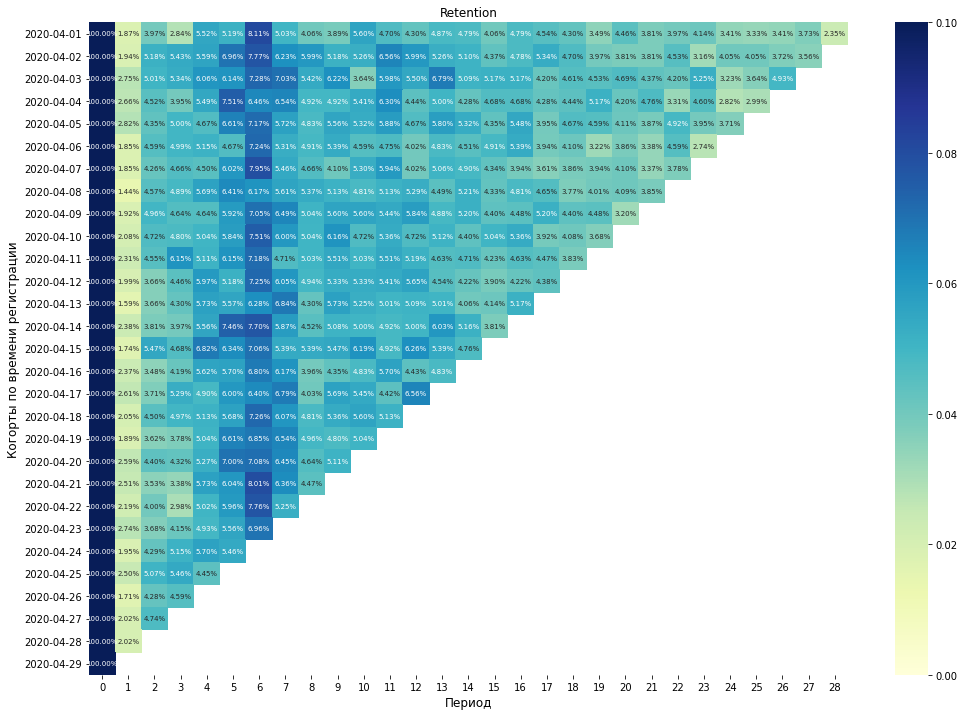

In [17]:
df_day = calculate_retention(reg_file_path='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-reg_data.csv',
                         auth_file_path ='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-auth_data.csv',
                         start_date ='2020-04-01',
                         end_date='2020-04-30',
                        cohort_type='daily')
df_day

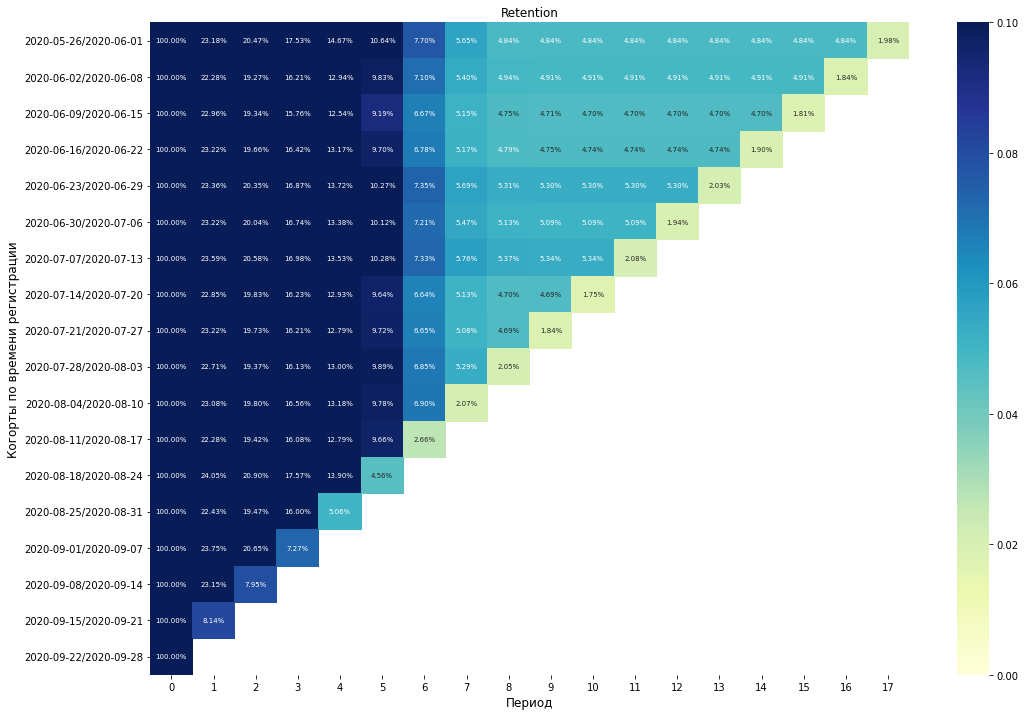

In [18]:
df_week = calculate_retention(reg_file_path='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-reg_data.csv',
                         auth_file_path ='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-auth_data.csv',
                         start_date ='2020-06-01',
                         end_date='2020-09-30',
                        cohort_type='weekly')
df_week

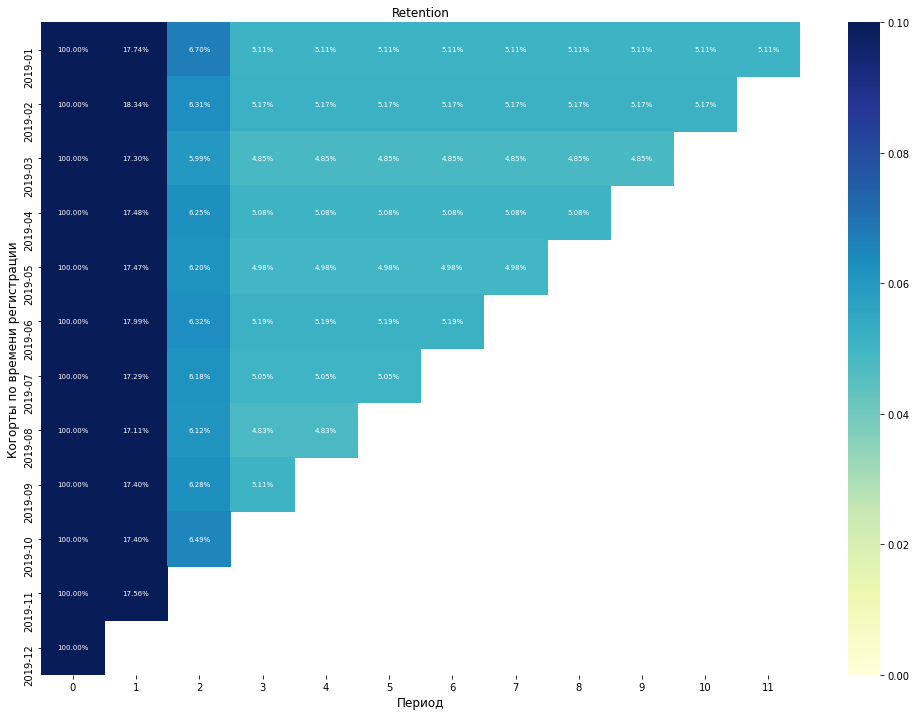

In [19]:
df_month = calculate_retention(reg_file_path='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-reg_data.csv',
                         auth_file_path ='/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/shared/problem1-auth_data.csv',
                         start_date ='2019-01-01',
                         end_date='2019-12-31',
                        cohort_type='monthly')
df_month

---

> ## 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
<br>
- Какой набор предложений можно считать лучшим? 
- Какие метрики стоит проанализировать для принятия правильного решения и как?

In [19]:
df_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [21]:
df = func_yandex_csv(df_key, sep=';', encoding='utf-8')
df.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [24]:
df.duplicated().sum()

0

In [25]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [26]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [27]:
df.user_id.nunique() == df.shape[0]

True

> в данных нет пропущенных значений и дубликатов, также все айди являются уникальными, т.е в группах нет пересечений

In [28]:
# добавим колонку paid == 1 с фиксацией оплаты 
df['paid'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)
df.head(3)

,user_id,revenue,testgroup,paid
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0


In [29]:
shared = df \
    .groupby(['testgroup'], as_index=False)\
    .agg({'user_id': 'count', 'revenue':'sum', 'paid': 'sum'})\
    .rename(columns={'user_id': 'users_count', 'paid': 'customers'})
shared

,testgroup,users_count,revenue,customers
0,a,202103,5136189,1928
1,b,202667,5421603,1805


In [30]:
shared['ARPU'] = round(shared.revenue / shared.users_count, 2) 
shared['ARPPU'] = round(shared.revenue / shared.customers, 2)
shared['CR'] = round(shared.customers / shared.users_count * 100, 2)
shared

,testgroup,users_count,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


In [117]:
print('ARPU группы_b больше на', round((shared.ARPU[1] / shared.ARPU[0] - 1)*100, 2),'%')
print('ARPPU группы_b больше на', round((shared.ARPPU[1] / shared.ARPPU[0] - 1)*100, 2),'%')
print('CR группы_b меньше на', round((1- shared.CR[1] / shared.CR[0])*100, 2),'%')

ARPU группы_b больше на 5.27 %
ARPPU группы_b больше на 12.75 %
CR группы_b меньше на 6.32 %


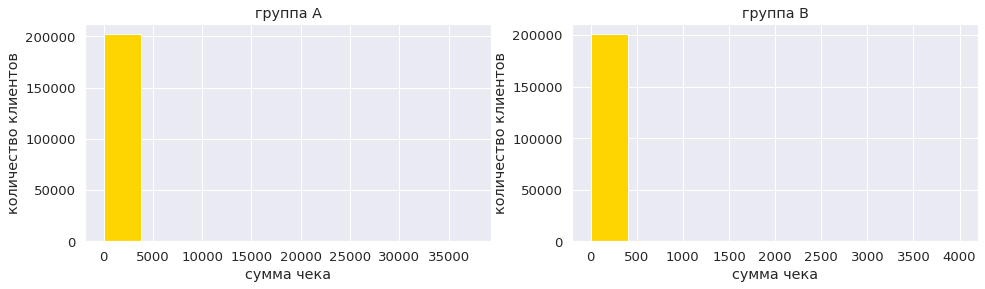

In [32]:
# визуализируем количество клиентов по сумме чека по каждой группе 
group_A = df.query('testgroup == "a"')
group_B = df.query('testgroup == "b"')
sns.set(font_scale=1.2, rc={'figure.figsize':(16,4)}, palette='hsv')
fig, axs = plt.subplots(1, 2)

axs[0].hist(group_A['revenue'], linewidth=1, edgecolor="white")
axs[0].set_title('группа А')
axs[0].set(xlabel='сумма чека', ylabel='количество клиентов')
axs[1].hist(group_B['revenue'], linewidth=1, edgecolor="white")
axs[1].set_title('группа В')
axs[1].set(xlabel='сумма чека', ylabel='количество клиентов')
sns.histplot()
plt.show()

In [33]:
print('A', group_A.revenue.describe())
print('B', group_B.revenue.describe())

A count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64
B count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64


> По визуализации видим ненормальное распределение и имеются выбросы в обеих группах

> `Проверим группы на нормальность распределения данных с помощью теста Колмогорова-Смирнова`
- **Н0**: значения распределены нормально
- **H1**: значения распределены ненормально


In [34]:
group_a = df.query('testgroup == "a"').revenue
group_b = df.query('testgroup == "b"').revenue

In [35]:
stats.kstest(group_a, 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

In [36]:
stats.kstest(group_b, 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

> pvalue < 0 в обеих группах, соответственно отвергаем нулевую гипотезу, данные распределены ненормально

> `Проверим равенство дисперсий с помощью метода Левина`
- **H0**: дисперсии внутри групп равны
- **H1**: дисперсии внутри групп не равны

In [115]:
statistic, pvalue = stats.levene(group_a, group_b)
print(f'Statistic {statistic}, pvalue {pvalue}')
if pvalue < 0.05:
    print('Отвергаем нулевую гипотезу - дисперсии не равны')
else:
    print("Принимаем нулевую гипотезу. Дисперсии статистически не различаются.")

Statistic 0.3896289474701388, pvalue 0.5324948591043842
Принимаем нулевую гипотезу. Дисперсии статистически не различаются.


In [38]:
shared

,testgroup,users_count,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


> ### CR
> А/В тестирование для CR будем проводить с помощью метода Хи-квадрат Пирсона.
- H0 - CR в группах не отличаются
- H1 - CR в группах имеют отличия

In [39]:
table = pd.crosstab(df['testgroup'], df['paid'])
table

paid,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [40]:
chi2, p_value, dof, expected = chi2_contingency(table)
print(f"χ²: {chi2}, p-значение: {p_value}")

χ²: 4.374729521260405, p-значение: 0.03647561892312613


> p-значение < 0.05, соответственно отвергаем нулевую гипотезу, **CR между группами отличается, у тестовой группы CR снизился!**

In [41]:
shared

,testgroup,users_count,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


> ### APRU
А/В тестирование для APRU будем проводить с помощью метода Бутстрап
- H0 - ARPU в группах не отличаются
- H1 - ARPU в группах имеют отличия

In [42]:
# очень долго 
# %%time
# pg.compute_bootci(group_a,
#          group_b,
#          n_boot=5000,
#          func=lambda x, y: np.mean(x) - np.mean(y))

In [89]:
df_a_ARPU = group_a # значения группы_А
df_b_ARPU = group_b # значения группы_В

num_samples = 1000 # кол-во выборок bootstrap
bootstrap_diffs = np.zeros(num_samples) # массив, заполненный нулями
 
# Выполняем выборку
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(df_a_ARPU, size=len(df_a_ARPU), replace=True)
    bootstrap_group2 = np.random.choice(df_b_ARPU, size=len(df_b_ARPU), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

# рассчитываем доверительный интервал  
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
 
print("95% Доверительный интервал ARPU:", confidence_interval)

95% Доверительный интервал ARPU: [-5.54942653  2.71240647]


In [90]:
data_ARPU = pd.DataFrame(bootstrap_diffs, columns=['difference'])
data_ARPU.head(3)

,difference
0,0.791524
1,-2.271548
2,-1.920337


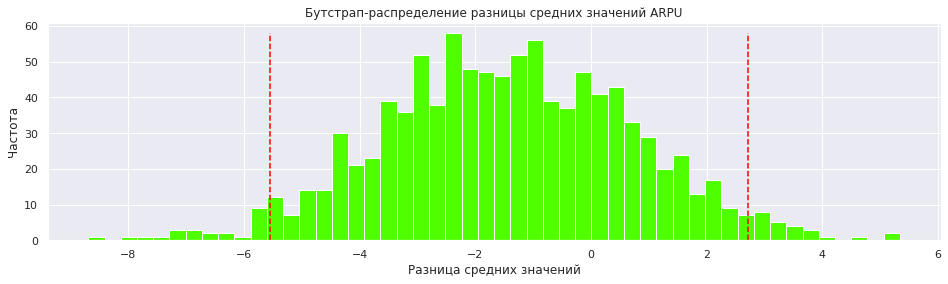

In [91]:
# визуализируем доверительный интервал 
sns.set(font_scale=1, 
        rc={'figure.figsize':(16, 4)}, palette='hsv')
plt.hist(data_ARPU['difference'], bins=50)
plt.vlines(confidence_interval, ymin=0, ymax=max(plt.hist(data_ARPU['difference'], bins=50)[0]),
           colors='red', linestyle='--')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title("Бутстрап-распределение разницы средних значений ARPU")
plt.show()

> С помощью метода Bootstrap мы видим, что в распределение разницы средних значений между группами **0** попадает в 95% доверительный интервал, соответственно можем принять нулевую гипотезу: ARPU группы_b статистически значимо не отличается от ARPU группы_а.
<br>
> **ARPU статистически значимо не изменился**


In [92]:
shared

,testgroup,users_count,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


> ### ARPPU
А/В тестирование для ARPPU будем проводить с помощью метода Бутстрап
- H0 - ARPPU в группах не отличаются
- H1 - ARPPU в группах имеют отличия

In [93]:
df_a = df.query('testgroup == "a" and paid == 1')
df_b = df.query('testgroup == "b" and paid == 1')

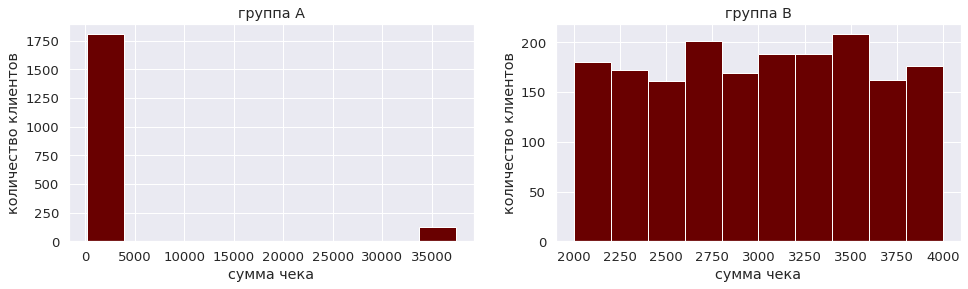

In [99]:
# визуализируем количество клиентов по сумме чека по каждой группе 
sns.set(font_scale=1.2, rc={'figure.figsize':(16,4)}, palette='hot')
fig, axs = plt.subplots(1, 2)

axs[0].hist(df_a['revenue'], linewidth=1, edgecolor="white")
axs[0].set_title('группа А')
axs[0].set(xlabel='сумма чека', ylabel='количество клиентов')
axs[1].hist(df_b['revenue'], linewidth=1, edgecolor="white")
axs[1].set_title('группа В')
axs[1].set(xlabel='сумма чека', ylabel='количество клиентов')
sns.histplot()
plt.show()

> `Проверим группы на нормальность распределения данных с помощью теста Колмогорова-Смирнова`
- **Н0**: значения распределены нормально
- **H1**: значения распределены ненормально

In [101]:
stats.kstest(df_a.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [103]:
stats.kstest(df_b.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

> pvalue < 0 в обеих группах, соответственно отвергаем нулевую гипотезу, данные распределены ненормально

> `Проверим равенство дисперсий с помощью метода Левина`
- **H0**: дисперсии внутри групп равны
- **H1**: дисперсии внутри групп не равны

In [105]:
statistic, pvalue = stats.levene(df_a.revenue, df_b.revenue)
print(f'Statistic {statistic}, pvalue {pvalue}')
if pvalue < 0.05:
    print('Отвергаем нулевую гипотезу - дисперсии не равны')
else:
    print("Принимаем нулевую гипотезу. Дисперсии статистически не различаются.")

Statistic 80.85567421779912, pvalue 3.779689868667878e-19
Отвергаем нулевую гипотезу - дисперсии не равны


In [95]:
df_a_ARPPU = df_a.revenue # значения группы_А
df_b_ARPPU = df_b.revenue # значения группы_В

num_samples = 1000 # кол-во выборок bootstrap
bootstrap_diffs = np.zeros(num_samples) # массив, заполненный нулями
 
# Выполняем выборку
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(df_a_ARPPU, size=len(df_a_ARPPU), replace=True)
    bootstrap_group2 = np.random.choice(df_b_ARPPU, size=len(df_b_ARPPU), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

# рассчитываем доверительный интервал  
confidence_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
 
print("95% Доверительный интервал ARPPU:", confidence_interval)

95% Доверительный интервал ARPPU: [-703.98779742   58.57158481]


In [96]:
data_ARPPU = pd.DataFrame(bootstrap_diffs, columns=['difference'])
data_ARPPU.head(3)

,difference
0,-243.983777
1,-337.157890
2,-402.999151


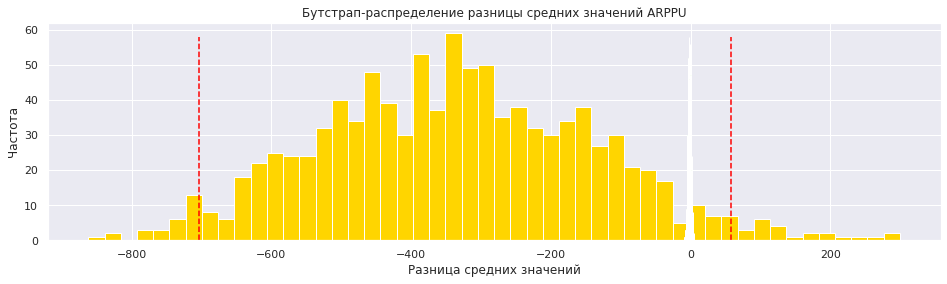

In [98]:
# визуализируем доверительный интервал 
sns.set(font_scale=1, 
        rc={'figure.figsize':(16, 4)}, palette='hsv')
plt.hist(data_ARPPU['difference'], bins=50)
plt.vlines(confidence_interval, ymin=0, ymax=max(plt.hist(data_ARPU['difference'], bins=50)[0]),
           colors='red', linestyle='--')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title("Бутстрап-распределение разницы средних значений ARPPU")
plt.show()

In [112]:
stats.bootstrap((df_a_ARPPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=2280.040193127273, high=3086.2554283290865), standard_error=205.50169307776153)

In [113]:
stats.bootstrap((df_b_ARPPU.values, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=2977.3786301564737, high=3030.2995612121695), standard_error=13.46232516773377)

> Получили 95% доверительный интервал для разницы средних revenue (ARPPU) в контрольной и тестовой группах, который покрывает 0. 
<br>
Это означает, что статистически значимого различия между ARPPU в контрольной и тестовой группах - нет.
<br>
В контрольной группе ARPPU = 2664, в тестовой группе ARPPU = 3003.66.
<br>
ARPPU статичстически значимо не изменился!

In [118]:
print('ARPU группы_b больше на', round((shared.ARPU[1] / shared.ARPU[0] - 1)*100, 2),'%')
print('ARPPU группы_b больше на', round((shared.ARPPU[1] / shared.ARPPU[0] - 1)*100, 2),'%')
print('CR группы_b меньше на', round((1- shared.CR[1] / shared.CR[0])*100, 2),'%')
shared

ARPU группы_b больше на 5.27 %
ARPPU группы_b больше на 12.75 %
CR группы_b меньше на 6.32 %


,testgroup,users_count,revenue,customers,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.41,2664.00,0.95
1,b,202667,5421603,1805,26.75,3003.66,0.89


> ### Вывод:

- **ARPU** (средний доход на пользователя) увеличился на 5% в тестовой группе, но это изменение не является статистически значимым.
- **ARPPU** (средний доход на платящего пользователя) также не изменился статистически значимо.
- **CR** (конверсия) снизился статистически значимо в тестовой группе.
<br><br>
1. **Снижение CR при неизменном ARPU и ARPPU**:
   - Снижение CR означает, что меньший процент пользователей стал платящим в тестовой группе по сравнению с контрольной группой.
   - Поскольку ARPU и ARPPU не изменились статистически значимо, увеличение ARPU на 5% в тестовой группе может быть случайным или незначительным в контексте общего дохода.

2. **Потенциальные риски и выгоды**:
   - **Риски**: Снижение конверсии (CR) может указывать на то, что предложенные изменения отпугнули часть пользователей от совершения покупок. Это может иметь негативные долгосрочные последствия, если количество платящих пользователей продолжит снижаться.
   - **Выгоды**: Увеличение ARPU могло бы быть положительным фактором, если бы оно было статистически значимым. Однако, без статистической значимости, это увеличение не может считаться надежным улучшением.

> ### Рекомендации:

1. **Долгосрочный анализ**:
   - Провести более длительный тест для наблюдения за долгосрочными трендами. Возможно, на более длительном интервале времени изменения в ARPU или ARPPU станут статистически значимыми.
<br><br>   
2. **Дополнительные метрики, на которые возможно стоит посмотреть**:
   - **LTV (Lifetime Value)**: Оценить долгосрочную ценность пользователей для обеих групп. Это поможет понять, какие изменения в акционных предложениях могут принести больший доход в долгосрочной перспективе.
   - **Retention Rate (уровень удержания пользователей)**: Проверить, как изменения влияют на удержание пользователей. Это может дать представление о том, насколько предложения привлекают пользователей к повторным покупкам.
   - **Churn Rate (отток пользователей)**: Анализировать, как изменения влияют на отток пользователей.
<br><br>
3. **Качественный анализ**:
   - Проведите опросы или фокус-группы, чтобы понять, почему конверсия снизилась. Возможно, предложения в тестовой группе не соответствуют ожиданиям пользователей или воспринимаются как менее выгодные.
<br><br>
4. **Корректировка акционных предложений**:
   - На основе собранной обратной связи и дополнительных метрик, возможно, потребуется скорректировать акционные предложения, чтобы они стали более привлекательными для пользователей, что может помочь восстановить конверсию.

> ### Заключение:

Текущие результаты показывают, что изменения в тестовой группе привели к статистически значимому снижению конверсии, без статистически значимых улучшений в ARPU и ARPPU. Таким образом, в текущем состоянии, контрольная группа с более высокой конверсией выглядит предпочтительнее. Однако, прежде чем принимать окончательное решение, стоит провести дополнительный анализ и, возможно, повторить эксперимент, учитывая долгосрочные метрики и качественные данные.


---

> ## 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 
- С помощью каких метрик можно оценить результаты последнего прошедшего события?


>Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 
- Изменится ли набор метрик оценки результата? Если да, то как?

> ### Оценка тематических событий упрощенной механики 

1. **Экономические метрики**:
   - **Общий доход от внутриигровых покупок (GIPR)**: Общий объем средств, потраченных игроками на внутриигровые покупки во время тематического события. В усложненной механике может измениться.
   - **Конверсия в платящих пользователей (PUC)**: Процент игроков, совершивших покупки во время тематического события.
<br><br>
2. **DAU (Daily Active Users)**:
   - Сравнить количество активных пользователей в дни проведения тематических событий и в обычные дни. Это позволит оценить, насколько события привлекают игроков.
<br><br>
3. **Коэффициент удержания**:
   - Сравнить коэффициенты удержания (отношение DAU к MAU) во время проведения тематических событий и в обычные дни. Это поможет понять, как события влияют на приверженность игроков к игре.
<br><br>
4. **Прохождение уровней**:
   - **Процент завершивших событие (CR)**: Процент игроков, успешно прошедших все уровни события. В усложненной механике этот показатель может снизиться.
   - **Среднее количество попыток на уровень (ATTPL)**: Среднее число попыток, необходимых для прохождения каждого уровня. В усложненной механике этот показатель, вероятно, увеличится.
<br><br>
5. **ACU (Average Concurrent Users)**:
   - Метрика среднее число пользователей за час (ACU) предоставляет данные о средней численности игроков, находящихся в игре в любой момент времени в течение часа. Это помогает оценить пиковую нагрузку на серверы и вовлеченность игроков в разные периоды времени. Сравнить эти показатели в тематические дни и обычные дни для
<br><br>
6. **Относительная и абсолютная конверсии**:
   - **Относительная конверсия**: Процент новых пользователей, привлеченных в игру благодаря тематическим событиям.
   - **Абсолютная конверсия**: Общее количество новых пользователей, привлеченных в игру благодаря тематическим событиям.
   - Эти метрики позволят определить, насколько эффективно проведение событий способствует привлечению новой аудитории.
<br><br>
7. **ASL (Average Session Length)**:
   - Сравнить среднюю продолжительность сессии в обычный день и тематический день. Это покажет, как события влияют на время, проводимое пользователями в игре.
<br><br>
8. **Коэффициент удержания (Retention Rate)**:
   - Анализировать удержание игроков на разных этапах события и после его завершения, чтобы понять долгосрочное влияние изменений на аудиторию.
<br><br>
9. **Интервалы между сессиями**:
   - Анализировать интервалы между сессиями для определения, как тематические события влияют на желание пользователей возвращаться в игру. Сравнить эти данные с обычными днями для выявления изменений в поведении игроков.
<br><br>
10. **Удовлетворенность игроков**:
   - **Средний рейтинг события (EAS)**: Средний рейтинг события по отзывам игроков, собранным через опросы или рейтинговую систему.
   - **Коэффициент удержания после события (RRPE)**: Процент игроков, продолживших играть после завершения события.
<br><br>
11. **Анализ отзывов и рейтингов**:
   - Оценка изменений в отзывах и рейтингах игры в период проведения событий. Это даст представление о восприятии игроками изменений в механике.

> ### Оценка тематических событий усложненной механики

Учитывая усложнение механики и возможность отката на несколько уровней назад при неудачной попытке, нужно дополнительно к вышеперечисленному учитывать следующие метрики:

1. **Среднее количество откатов**:
   - Рассчитать среднее количество откатов на игрока. Это поможет оценить устойчивость игроков к негативным событиям.
<br><br>
2. **Процент пользователей, которые вышли после первой неудачной попытки**:
   - Определить процент пользователей, которые прекратили играть после первой неудачной попытки. Это поможет оценить влияние негативного опыта на удержание игроков.
<br><br>
3. **Средняя продолжительность игры после неудачной попытки**:
   - Измерить среднее время, проведенное в игре после неудачной попытки. Это позволит понять, насколько откат влияет на желание пользователей продолжать играть.

> ### Заключение

При анализе результатов событий в игре важно учитывать как стандартные метрики, так и специфические показатели, зависящие от изменений в механике игры. Постоянный мониторинг и адаптация метрик помогут точно оценивать влияние изменений и принимать обоснованные решения для будущих событий.